In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from performance_measures import c_index, brier_score, weighted_c_index, weighted_brier_score,log_partial_lik
from neural_models import negLogLikelihood, linearCoxPH_Regression, MLP, negLogLikelihood_per_sample
from fairness_measures import individual_fairness, group_fairness, intersect_fairness, individual_fairness_scale, CI, C_index_difference
from utilities import prepare_data3

from sksurv.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import brier_score_loss
from sksurv.metrics import concordance_index_censored, brier_score, integrated_brier_score
from sksurv.metrics import concordance_index_ipcw,cumulative_dynamic_auc
from sklearn.linear_model import QuantileRegressor
from sksurv.util import Surv
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from scipy import optimize
from compute_survival_function import predict_survival_function  

# Simulation
from cox_dgp_simulation import simulate_cox_dgp, simulate_weibull_failure_cox
from numpy.random import normal, uniform, exponential, binomial, beta, weibull
from scipy.stats import norm

#The function below ensures that we seed all random generators with the same value to get reproducible results
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

def threshplus(x):
    y = x.copy()
    y[y<0]=0
    return y

def threshplus_tensor(x):
    y = x.clone()
    y[y<0]=0
    return y

def loss_map_chi_factory(loss_values, eps):
    # return lambda x: np.sqrt(2)*(1.0/eps-1.0)*np.sqrt(np.mean(threshplus(loss_values-x)**2.0)) + x
    return lambda x: np.sqrt(2 * ((1.0 / eps - 1.0)** 2.0)+1) * np.sqrt(np.mean(threshplus(loss_values - x) ** 2.0)) + x

def loss_map_chi_factory_tensor(loss_values, eps, opt_eta):
    # return np.sqrt(2)*(1.0/eps-1.0)*torch.sqrt(torch.mean(threshplus_tensor(loss_values-opt_eta)**2.0)) + opt_eta
    return np.sqrt(2 * ((1.0 / eps - 1.0)** 2.0)+1)*torch.sqrt(torch.mean(threshplus_tensor(loss_values-opt_eta)**2.0)) + opt_eta

In [146]:
def bs_indiv(t, surv_func, failure_time):
    is_failed = (failure_time <= t)
    St = np.array([S(t) for S in surv_func])
    return is_failed*St**2 + (1 - is_failed)*(1-St)**2

def integrated_bs_indiv(t_grids, surv_func, failure_time):
    bs_array = np.array([bs_indiv(t, surv_func, failure_time) for t in t_grids])
    weights = np.diff(t_grids)/(max(t_grids) - min(t_grids))
    return np.dot(weights, (bs_array[:-1,:] + bs_array[1:,:])/2)

# Functions for model fitting

## Torch

In [24]:
def fit_dro_cox(X, event, time, eps=0.1, lr=0.01, epochs=500):
    """Fit DRO-Cox model, return a nn.module instance"""
    X, event, time = prepare_data3(X, event, time) # sort the data by time for fitting cox model
    X = Variable((torch.from_numpy(X)).float())
    event = Variable((torch.from_numpy(event)).float())
    time = Variable((torch.from_numpy(time)).float())

    criterion_per_sample = negLogLikelihood_per_sample()
    model = linearCoxPH_Regression(X.shape[1],1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        # Original loss
        outputs = model(X)
        per_sample_losses = criterion_per_sample(outputs, event)

        # Update eta with beta fixed
        chi_loss_np = loss_map_chi_factory(per_sample_losses.detach().numpy(), eps)
        cutpt = optimize.fminbound(chi_loss_np, np.min(per_sample_losses.detach().numpy()) - 1000.0, np.max(per_sample_losses.detach().numpy()))

        # Update beta with eta fixed
        loss = loss_map_chi_factory_tensor(per_sample_losses, eps, cutpt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, cutpt

def eval_test(beta_fitted, beta_dgp, X_test):
    """Directly comparate the fitted beta to the true beta"""
    return np.dot(X_test, beta_dgp-beta_fitted)**2

In [4]:
class std_exp_baseline_negLogLikelihood_per_sample(nn.Module):
    # Source: deepSurv implementation with PyTorch (https://gitlab.com/zydou/deepsurv/-/tree/master/DeepSurv-Pytorch)
    def __init__(self):
        super(std_exp_baseline_negLogLikelihood_per_sample, self).__init__()

    def forward(self, prediction, time, event):
        censored_likelihood = -event.float() * prediction + time*torch.exp(prediction)
        return censored_likelihood

def fit_std_exp_baseline_dro_cox(X, event, time, eps=0.1, lr=0.01, epochs=500):
    """Fit DRO-Cox model, return a nn.module instance"""
    X, event, time = prepare_data3(X, event, time) # sort the data by time for fitting cox model
    X = Variable((torch.from_numpy(X)).float())
    event = Variable((torch.from_numpy(event)).float())
    time = Variable((torch.from_numpy(time)).float())

    criterion_per_sample = std_exp_baseline_negLogLikelihood_per_sample()
    model = linearCoxPH_Regression(X.shape[1],1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    is_dro = (eps - 1.0 < 10e-6)
    for epoch in range(epochs):
        # Original loss
        outputs = model(X)
        per_sample_losses = criterion_per_sample(outputs, time, event)

        if is_dro:
            # Update eta with beta fixed
            chi_loss_np = loss_map_chi_factory(per_sample_losses.detach().numpy(), eps)
            cutpt = optimize.fminbound(chi_loss_np, np.min(per_sample_losses.detach().numpy()) - 1000.0, np.max(per_sample_losses.detach().numpy()))

            # Update beta with eta fixed
            loss = loss_map_chi_factory_tensor(per_sample_losses, eps, cutpt)
        else:
            loss = torch.mean(per_sample_losses)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if is_dro:
        return model, cutpt
    else:
        return model, np.nan

## Scipy

In [25]:
class DroOptimizer:
    def __init__(self, loss_func, eps):
        self.loss_func = loss_func
        self.eps = eps
        self.beta = None
        self.eta = None

    def dro_loss(self, beta, eta, X, y, is_beta0_intercept=False, verbose=False, **kwargs):
        if is_beta0_intercept:
            pred = beta[0] + np.dot(X, beta[1:])
        else:
            pred = np.dot(X, beta)
        out = np.sqrt(2 * ((1.0 / self.eps - 1.0)** 2.0)+1) * np.sqrt(np.mean(threshplus(self.loss_func(pred, y, **kwargs) - eta) ** 2.0)) + eta
        if verbose:
            print(f"beta = {beta}, eta = {eta}, dro loss = {out}")
        return out

    def fit_dro(self, X, y, is_include_intercept=False, verbose=False, **kwargs):
        func = lambda para: self.dro_loss(para[:-1], para[-1], X, y, verbose, **kwargs)
        para_len = X.shape[1] + 1
        para_len += 1 if is_include_intercept else 0
        para_init = normal(size=para_len)
        self.optimizer = optimize.minimize(fun=func, x0=para_init)
        para_fitted = self.optimizer.x
        self.beta = para_fitted[:-1]
        self.eta = para_fitted[-1]

    def predict(self, X):
        out = np.dot(X, self.beta)
        return out

# DRO-Cox (known baseline)

In [ ]:
set_random_seed()
# Simiulation config
sim_n_train = 500 # Number of training samples in one batch
n_cov = 5 # Number of covariates
censor_rate = 0.4

sim_n_test = 10000 # Number of testing samples
shift_radian_candidates = np.linspace(0, np.pi, 10)

beta = normal(size = n_cov)
beta /= np.sqrt(np.dot(beta, beta))

v = normal(size = n_cov)
v[0] -= np.dot(beta, v)/beta[0]
v /= np.sqrt(np.dot(v, v))

log_hr_linear = lambda X, beta: np.dot(X, beta)
    
# Model config
#eps_candidates = np.linspace(0.1, 1.0, 6)
eps_candidates = [1.1]

avg_test_loss = np.zeros((len(eps_candidates), len(shift_radian_candidates)))
test_loss_90quantile = np.zeros((len(eps_candidates), len(shift_radian_candidates)))
beta_fitted = np.zeros((len(eps_candidates), len(beta)))
eta_fitted_array = np.zeros(len(eps_candidates))

# Simulation
# Simulate training set
sim_X_train = normal(size=(sim_n_train, len(beta)))
log_hr_train = log_hr_linear(sim_X_train, beta)
_, _, sim_event_train, sim_time_train = simulate_cox_dgp(log_hr_train, sim_n=sim_n_train, censor_rate=censor_rate, )
sim_X_train, sim_event_train, sim_time_train = prepare_data3(sim_X_train, sim_event_train, sim_time_train)
sim_X_test = normal(size=(sim_n_test, len(beta)))

# Train models
for eps_ind, eps in enumerate(eps_candidates):
    model, eta_fitted_array[eps_ind] = fit_std_exp_baseline_dro_cox(sim_X_train, sim_event_train, sim_time_train, eps = eps)
    beta_fitted[eps_ind,:] = next(model.parameters()).detach().numpy().reshape((-1,))
    for shift_ind, shift_radian in enumerate(shift_radian_candidates):
        beta_shifted = beta*np.cos(shift_radian) + v*np.sin(shift_radian)
        avg_test_loss[eps_ind, shift_ind] = np.mean(eval_test(beta_fitted[eps_ind,:], beta_shifted, sim_X_test))
        test_loss_90quantile[eps_ind, shift_ind] = np.quantile(eval_test(beta_fitted[eps_ind,:], beta_shifted, sim_X_test), 0.9)

In [183]:
sim_time_train

array([1.47879535e+01, 1.19112785e+01, 9.67123710e+00, 9.29530829e+00,
       9.00548175e+00, 8.47826259e+00, 7.78117001e+00, 7.61035186e+00,
       6.96317356e+00, 6.90125576e+00, 6.78679178e+00, 6.77333359e+00,
       6.68635651e+00, 6.49053597e+00, 6.04655145e+00, 5.93275003e+00,
       5.69593778e+00, 5.69293776e+00, 5.59582607e+00, 5.25275866e+00,
       4.99808925e+00, 4.92815029e+00, 4.73194229e+00, 4.28899890e+00,
       4.28454834e+00, 4.27691730e+00, 4.02653248e+00, 3.95212040e+00,
       3.67777847e+00, 3.48560507e+00, 3.43361196e+00, 3.39568627e+00,
       3.35762471e+00, 3.30129654e+00, 3.24397199e+00, 3.24287781e+00,
       3.13234323e+00, 3.05464380e+00, 3.05060573e+00, 3.02093840e+00,
       2.97976888e+00, 2.97117477e+00, 2.86994061e+00, 2.86509804e+00,
       2.83791036e+00, 2.80547139e+00, 2.67361847e+00, 2.63170679e+00,
       2.62349343e+00, 2.57668169e+00, 2.54320372e+00, 2.51575621e+00,
       2.44619154e+00, 2.39877435e+00, 2.38841792e+00, 2.33657960e+00,
      

In [175]:
beta_fitted

array([[-0.00093605, -0.02036112, -0.0127922 , -0.0224511 ,  0.00862151]])

# DRO-Linear Simulation

In [175]:
def simulate_linear_subpop_dgp(beta_major, beta_minor, sigma = 0.1, sim_n=200, G_dist = lambda n: binomial(1, 0.9, n)):
    sim_X = normal(size=(sim_n, len(beta_major)))
    G = G_dist(sim_n)
    eta = G*np.dot(sim_X, beta_major) + (1 - G)*np.dot(sim_X, beta_minor)
    sim_y = normal(loc=eta, scale=sigma).reshape((-1,1))
    return sim_X, sim_y

In [176]:
def fit_dro_linear(X, y, eps=0.1, lr=0.01, epochs=500):
    X = Variable((torch.from_numpy(X)).float())
    y = Variable((torch.from_numpy(y)).float())

    criterion_per_sample = nn.MSELoss(reduction='none')
    model = linearCoxPH_Regression(X.shape[1],1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        # Original loss
        outputs = model(X)
        per_sample_losses = criterion_per_sample(outputs, y)

        # Update eta with beta fixed
        chi_loss_np = loss_map_chi_factory(per_sample_losses.detach().numpy(), eps)
        #print(per_sample_losses.detach().numpy())
        cutpt = optimize.fminbound(chi_loss_np, np.min(per_sample_losses.detach().numpy()) - 1000.0, np.max(per_sample_losses.detach().numpy()))

        # Update beta with eta fixed
        loss = loss_map_chi_factory_tensor(per_sample_losses, eps, cutpt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, cutpt

In [181]:
set_random_seed(1)
# Simiulation config
sim_n_train = 1000
sim_n_test = 10000

beta_major = np.array([1,1])
beta_minor = np.array([1,2])
G_dist = lambda n: binomial(1, 0.9, n)

# Model config
eps_candidates = np.linspace(0.05, 1.0, 10)
G_test_candidates = np.array([0,1])
avg_test_loss = np.zeros((len(eps_candidates), len(G_test_candidates)))
beta_fitted = np.zeros((len(eps_candidates), len(beta_major)))
eta_fitted = np.zeros(len(eps_candidates))

# Simulation
# Train model
sim_X_train, sim_y_train = simulate_linear_subpop_dgp(beta_major, beta_minor, sigma=0.1, sim_n=sim_n_train, G_dist=G_dist)
sim_X_test = normal(scale=0.1, size=(sim_n_test, len(beta_major)))
for eps_ind, eps in enumerate(eps_candidates):
    model, eta_fitted[eps_ind] = fit_dro_linear(sim_X_train, sim_y_train, eps = eps, epochs=500)
    beta_fitted[eps_ind,:] = next(model.parameters()).detach().numpy().reshape((-1,))
    for G_ind, G in enumerate(G_test_candidates):
        avg_test_loss[eps_ind, G_ind] = eval_test(beta_fitted=beta_fitted[eps_ind,:], beta_dgp=G*beta_major + (1 - G)*beta_minor, X_test=sim_X_test).mean()

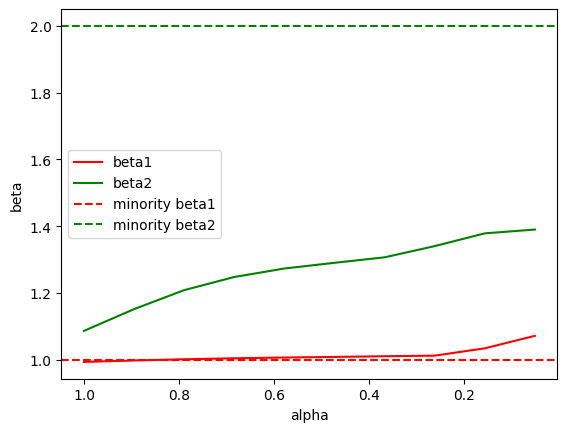

In [184]:
plt.plot(eps_candidates, beta_fitted[:,0], label = 'beta1', color='red')
plt.plot(eps_candidates, beta_fitted[:,1], label = 'beta2', color='green')
plt.axhline(y=beta_minor[0], color='red', linestyle='--', label='minority beta1')
plt.axhline(y=beta_minor[1], color='green', linestyle='--', label='minority beta2')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

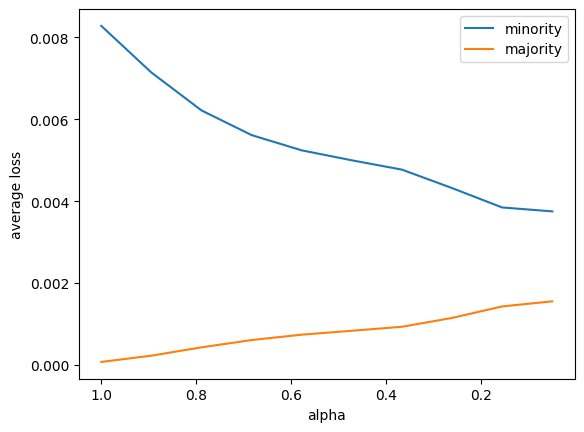

In [185]:
plt.plot(eps_candidates, avg_test_loss[:,0], label = 'minority')
plt.plot(eps_candidates, avg_test_loss[:,1], label = 'majority')
plt.xlabel('alpha')
plt.ylabel('average loss')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

In [ ]:
def simulate_linear_subpop_dgp(beta_major, beta_minor, sigma = 0.1, sim_n=200, G_dist = lambda n: binomial(1, 0.9, n)):
    sim_X = normal(size=(sim_n, len(beta_major)))
    G = G_dist(sim_n)
    eta = G*np.dot(sim_X, beta_major) + (1 - G)*np.dot(sim_X, beta_minor)
    sim_y = normal(loc=eta, scale=sigma).reshape((-1,1))
    return sim_X, sim_y

In [ ]:
def fit_dro_linear(X, y, eps=0.1, lr=0.01, epochs=500):
    X = Variable((torch.from_numpy(X)).float())
    y = Variable((torch.from_numpy(y)).float())

    criterion_per_sample = nn.MSELoss(reduction='none')
    model = linearCoxPH_Regression(X.shape[1],1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        # Original loss
        outputs = model(X)
        per_sample_losses = criterion_per_sample(outputs, y)

        # Update eta with beta fixed
        chi_loss_np = loss_map_chi_factory(per_sample_losses.detach().numpy(), eps)
        #print(per_sample_losses.detach().numpy())
        cutpt = optimize.fminbound(chi_loss_np, np.min(per_sample_losses.detach().numpy()) - 1000.0, np.max(per_sample_losses.detach().numpy()))

        # Update beta with eta fixed
        loss = loss_map_chi_factory_tensor(per_sample_losses, eps, cutpt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model, cutpt

In [ ]:
set_random_seed(1)
# Simiulation config
sim_n_train = 1000
sim_n_test = 10000

beta_major = np.array([1,1])
beta_minor = np.array([1,0.1])
G_dist = lambda n: binomial(1, 0.9, n)

# Model config
eps_candidates = np.linspace(0.05, 1.0, 20)
G_test_candidates = np.array([0,1])
avg_test_loss = np.zeros((len(eps_candidates), len(G_test_candidates)))
beta_fitted = np.zeros((len(eps_candidates), len(beta_major)))
eta_fitted = np.zeros(len(eps_candidates))

# Simulation
# Train model
sim_X_train, sim_y_train = simulate_linear_subpop_dgp(beta_major, beta_minor, sigma=0.1, sim_n=sim_n_train, G_dist=G_dist)
sim_X_test = normal(scale=0.1, size=(sim_n_test, len(beta_major)))
for eps_ind, eps in enumerate(eps_candidates):
    model, eta_fitted[eps_ind] = fit_dro_linear(sim_X_train, sim_y_train, eps = eps, epochs=500)
    beta_fitted[eps_ind,:] = next(model.parameters()).detach().numpy().reshape((-1,))
    for G_ind, G in enumerate(G_test_candidates):
        avg_test_loss[eps_ind, G_ind] = eval_test(beta_fitted=beta_fitted[eps_ind,:], beta_dgp=G*beta_major + (1 - G)*beta_minor, X_test=sim_X_test).mean()

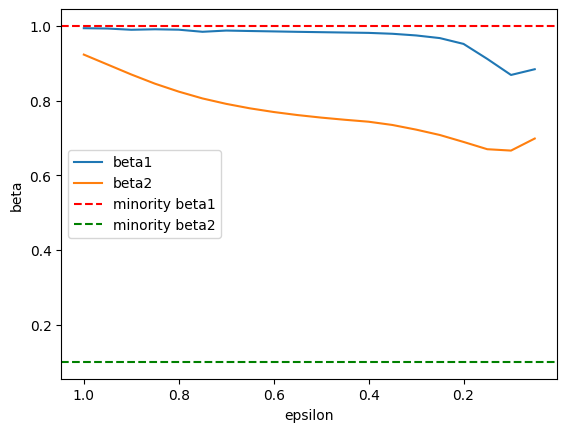

In [ ]:
plt.plot(eps_candidates, beta_fitted[:,0], label = 'beta1')
plt.plot(eps_candidates, beta_fitted[:,1], label = 'beta2')
plt.axhline(y=beta_minor[0], color='red', linestyle='--', label='minority beta1')
plt.axhline(y=beta_minor[1], color='green', linestyle='--', label='minority beta2')
plt.xlabel('epsilon')
plt.ylabel('beta')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

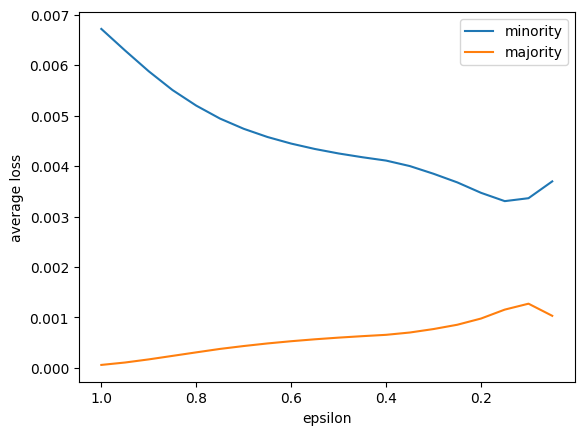

In [ ]:
plt.plot(eps_candidates, avg_test_loss[:,0], label = 'minority')
plt.plot(eps_candidates, avg_test_loss[:,1], label = 'majority')
plt.xlabel('epsilon')
plt.ylabel('average loss')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

# Distributional Shift

In [ ]:
set_random_seed(1234)
sq_error_loss_indiv = lambda pred, y: (y - pred)**2

# Simulation configs
sim_n_train = 100
sim_n_test = 10000
n_cov = 5 # Number of covariates
censor_rate = 0.4
S0_shape = 12.0
S0_scale = 1.0

shift_radian_candidates = np.linspace(0, np.pi, 10)

beta = normal(size = n_cov)
beta /= np.sqrt(np.dot(beta, beta))

v = normal(size = n_cov)
v[0] -= np.dot(beta, v)/beta[0]
v /= np.sqrt(np.dot(v, v))

# Data generation
# Training set
sim_X_train = normal(size=(sim_n_train, len(beta)))
log_hr_train = np.dot(sim_X_train, beta)
_, _, sim_event_train, sim_time_train = simulate_weibull_failure_cox(log_hr_train, S0_shape=S0_shape, S0_scale=S0_scale, censor_rate=censor_rate)
sim_X_train, sim_event_train, sim_time_train = prepare_data3(sim_X_train, sim_event_train, sim_time_train) # Prepare for cox model

# Arrays for storing simulation results
eps_candidates = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
avg_test_loss = np.zeros((len(eps_candidates), len(shift_radian_candidates)))
test_loss_90quantile = np.zeros((len(eps_candidates), len(shift_radian_candidates)))
beta_fitted = np.zeros((len(eps_candidates), len(beta)))
eta_fitted_array = np.zeros(len(eps_candidates))
t_grids = np.linspace(*np.quantile(sim_time_train, [0.025, 0.975]), 100)

for eps_ind, eps in enumerate(eps_candidates):
    model, eta_fitted_array[eps_ind] = fit_dro_cox(sim_X_train, sim_event_train, sim_time_train, eps = eps)
    beta_fitted[eps_ind,:] = next(model.parameters()).detach().numpy().reshape((-1,))

for shift_ind, shift_radian in enumerate(shift_radian_candidates):
    sim_X_test = normal(size=(sim_n_test, len(beta)))
    beta_shifted = beta*np.cos(shift_radian) + v*np.sin(shift_radian)
    log_hr_test = np.dot(sim_X_test, beta_shifted)
    sim_failure_time_test, _, _, _ = simulate_weibull_failure_cox(log_hr_test, S0_shape=S0_shape, S0_scale=S0_scale, censor_rate=censor_rate)
    for eps_ind, eps in enumerate(eps_candidates):
        surv_func = predict_survival_function(np.dot(sim_X_train, beta_fitted[eps_ind,:]), sim_event_train, sim_time_train, np.dot(sim_X_test, beta_fitted[eps_ind,:]))
        test_loss_indiv = integrated_bs_indiv(t_grids, surv_func, sim_failure_time_test)
        avg_test_loss[eps_ind, shift_ind] = test_loss_indiv.mean()
        test_loss_90quantile[eps_ind, shift_ind] = np.quantile(test_loss_indiv, 0.9)

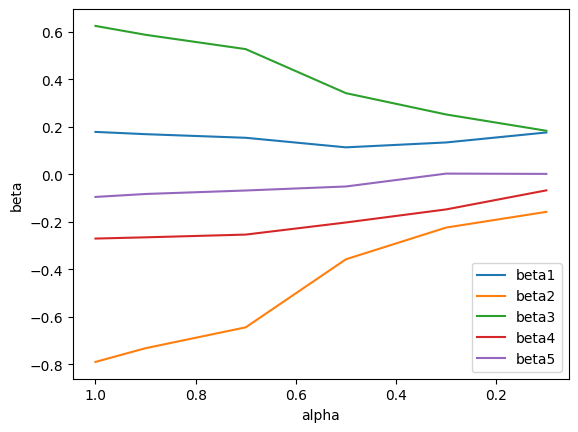

In [164]:
for beta_ind, beta in enumerate(beta_fitted.T):
    plt.plot(eps_candidates, beta, label = f'beta{beta_ind+1}')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

In [150]:
beta_fitted

array([[ 0.17617132, -0.15778002,  0.18336381, -0.06736013,  0.00190859],
       [ 0.13422041, -0.22392945,  0.25190884, -0.14751768,  0.00315317],
       [ 0.11361676, -0.3573167 ,  0.34163395, -0.20246807, -0.0510229 ],
       [ 0.15385175, -0.6436373 ,  0.52684426, -0.25341675, -0.06791409],
       [ 0.16905522, -0.7314893 ,  0.58715093, -0.26499456, -0.08260468],
       [ 0.17861199, -0.7891767 ,  0.62449384, -0.27014038, -0.09502111]])

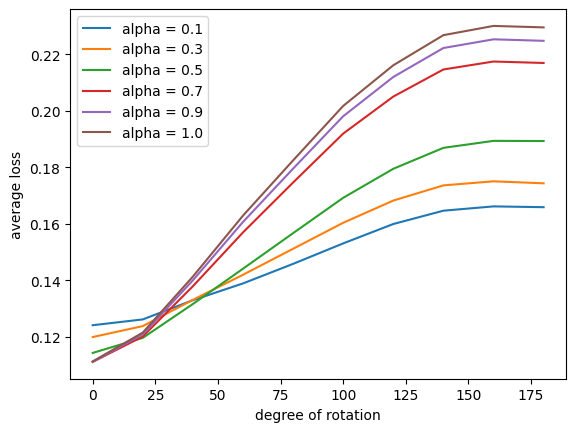

In [165]:
for i, eps in enumerate(eps_candidates):
    plt.plot(shift_radian_candidates*180/np.pi, avg_test_loss[i,:], label = f"alpha = {round(eps,2)}")
plt.xlabel('degree of rotation')
plt.ylabel('average loss')
plt.legend()
plt.show()

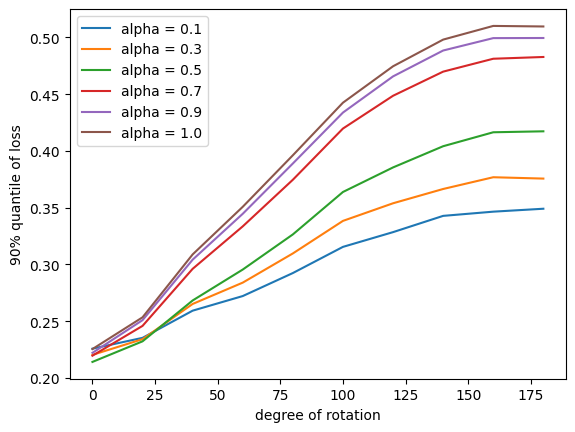

In [152]:
for i, eps in enumerate(eps_candidates):
    plt.plot(shift_radian_candidates*180/np.pi, test_loss_90quantile[i,:], label = f"alpha = {round(eps,2)}")
plt.xlabel('degree of rotation')
plt.ylabel('90% quantile of loss')
plt.legend()
plt.show()

# Tail performance

In [166]:
set_random_seed(10)
sq_error_loss_indiv = lambda pred, y: (y - pred)**2

# Simiulation config
sim_n_train = 1000
n_cov = 5
censor_rate = 0.4
S0_shape = 12.0
S0_scale = 1.0
sim_n_test = 10000

# Unit sphere beta
beta = normal(size = n_cov)
beta /= np.sqrt(np.dot(beta, beta))
beta_1_shift = 1

# Grids
eps_candidates = np.linspace(0.1, 1.0, 10)
avg_test_loss = np.zeros((len(eps_candidates), 2))
beta_fitted = np.zeros((len(eps_candidates), len(beta)))
eta_fitted = np.zeros(len(eps_candidates))

# Simulation
# Training set
sim_X_train = normal(size=(sim_n_train, len(beta)))
log_hr_train = np.dot(sim_X_train, beta) + (sim_X_train[:,0] > 1.645)*beta_1_shift
_, _, sim_event_train, sim_time_train = simulate_weibull_failure_cox(log_hr_train, S0_shape=S0_shape, S0_scale=S0_scale, censor_rate=censor_rate)
sim_X_train, sim_event_train, sim_time_train = prepare_data3(sim_X_train, sim_event_train, sim_time_train) # Prepare for cox model

# Test set
sim_X_test = normal(size=(sim_n_test, len(beta)))
log_hr_test = np.dot(sim_X_test, beta) + (sim_X_test[:,0] > 1.645)*beta_1_shift
sim_failure_time_test, _, _, _ = simulate_weibull_failure_cox(log_hr_test, S0_shape=S0_shape, S0_scale=S0_scale, censor_rate=censor_rate)
# beta_shifted = beta
# beta_shifted[0] += beta_1_shift
for eps_ind, eps in enumerate(eps_candidates):
    model, eta_fitted[eps_ind] = fit_dro_cox(sim_X_train, sim_event_train, sim_time_train, eps = eps)
    beta_fitted[eps_ind,:] = next(model.parameters()).detach().numpy().reshape((-1,))
    surv_func = predict_survival_function(np.dot(sim_X_train, beta_fitted[eps_ind,:]), sim_event_train, sim_time_train, np.dot(sim_X_test, beta_fitted[eps_ind,:]))
    test_loss_indiv = integrated_bs_indiv(np.linspace(*np.quantile(sim_time_train, [0.025, 0.975]), 100), surv_func, sim_failure_time_test)
    avg_test_loss[eps_ind, 0] = test_loss_indiv.mean()
    avg_test_loss[eps_ind, 1] = np.quantile(test_loss_indiv, 0.95)
    print(eps)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0


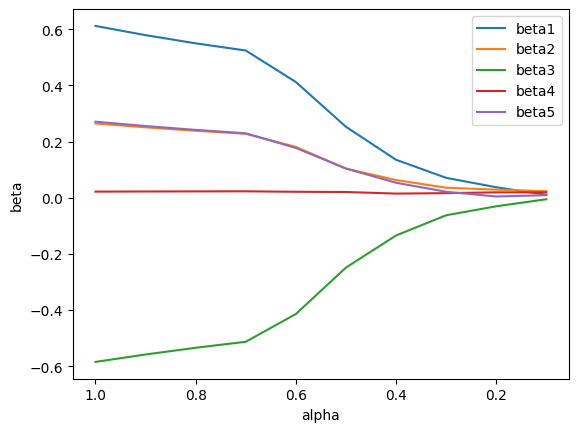

In [168]:
for i in range(beta_fitted.shape[1]):
    plt.plot(eps_candidates, beta_fitted[:,i], label = f'beta{i+1}')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

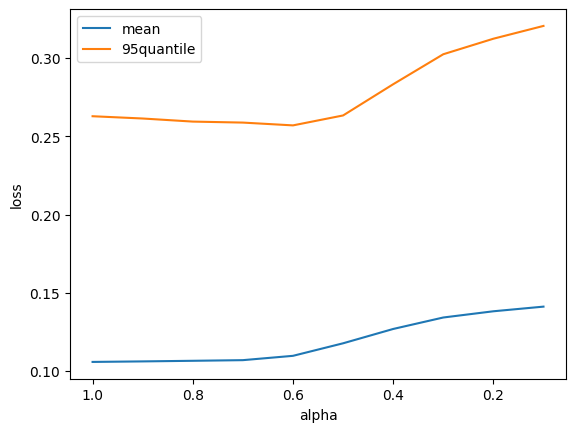

In [171]:
plt.plot(eps_candidates, avg_test_loss[:,0], label = 'mean')
plt.plot(eps_candidates, avg_test_loss[:,1], label = '95quantile')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

# Subpopulations

### Two subpopulations

-----0.10-----
-----0.20-----
-----0.30-----
-----0.40-----
-----0.50-----
-----0.60-----
-----0.70-----
-----0.80-----
-----0.90-----
-----1.00-----


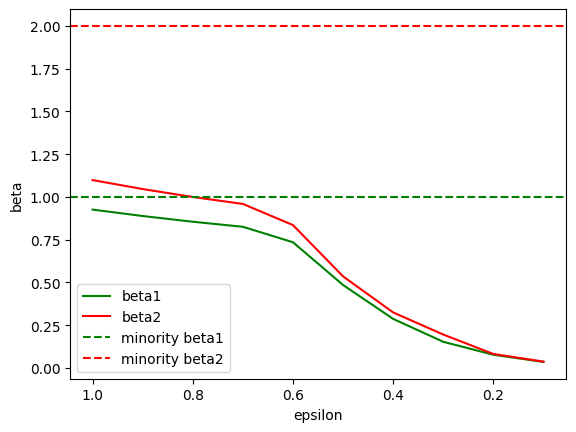

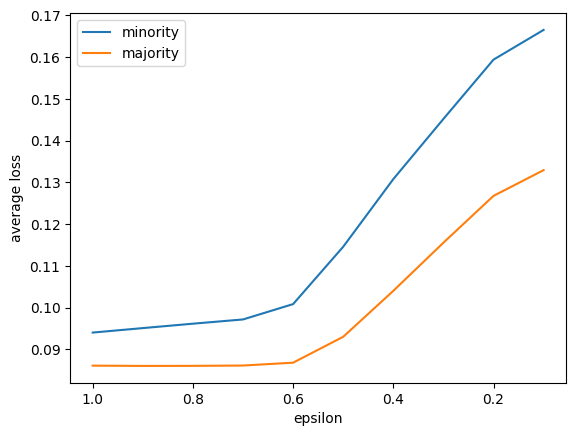

In [ ]:
set_random_seed(1234)
sq_error_loss_indiv = lambda pred, y: (y - pred)**2

# Simulation configs
sim_n_train = 1000
sim_n_test = 10000
censor_rate = 0.4
beta_major = np.array([1,1])
beta_minor = np.array([1,2])
minor_prop = 0.1
S0_shape = 12.0
S0_scale = 1.0
G_dist = lambda n: binomial(1, 1-minor_prop, n)

# Data generation
# Training set
sim_X_train = normal(size=(sim_n_train, len(beta_major)))
G_train = G_dist(sim_n_train)
log_hr_major_train = np.dot(sim_X_train, beta_major)
log_hr_minor_train = np.dot(sim_X_train, beta_minor)
log_hr_train = G_train*log_hr_major_train + (1-G_train)*log_hr_minor_train
sim_failure_time_train, sim_censor_time_train, sim_event_train, sim_time_train = simulate_weibull_failure_cox(log_hr_train, S0_shape=S0_shape, S0_scale=S0_scale, censor_rate=censor_rate)

# Test set
sim_X_test = normal(size=(sim_n_test, len(beta_major)))
log_hr_major_test = np.dot(sim_X_test, beta_major)
log_hr_minor_test = np.dot(sim_X_test, beta_minor)
G_test = G_dist(sim_n_test)
log_hr_test = G_test*log_hr_major_test + (1-G_test)*log_hr_minor_test
# sim_failure_time_major_test, sim_censor_time_major_test, sim_event_major_test, sim_time_major_test = simulate_weibull_failure_cox(log_hr_major_test, S0_shape=S0_shape, censor_rate=censor_rate)
# sim_failure_time_minor_test, sim_censor_time_minor_test, sim_event_minor_test, sim_time_minor_test = simulate_weibull_failure_cox(log_hr_minor_test, S0_shape=S0_shape, censor_rate=censor_rate)
sim_failure_time_test, sim_censor_time_test, sim_event_test, sim_time_test = simulate_weibull_failure_cox(log_hr_test, S0_shape=S0_shape, S0_scale=S0_scale, censor_rate=censor_rate)

# Arrays for storing simulation results
eps_candidates = np.linspace(0.1, 1.0, 10)
G_test_candidates = np.array([0,1])
beta_fitted = np.zeros((len(eps_candidates), len(beta_major)))
eta_fitted = np.zeros((len(eps_candidates)))
dro_loss_fitted = np.zeros((len(eps_candidates)))
test_loss = np.zeros((len(eps_candidates), len(G_test_candidates)))
t_grids = np.linspace(*np.quantile(sim_time_train, [0.025, 0.975]), 100)

for eps_ind, eps in enumerate(eps_candidates):
    # Fit model
    model, eta_fitted[eps_ind] = fit_dro_cox(sim_X_train, sim_event_train, sim_time_train, eps=eps)
    beta_fitted[eps_ind,:] = next(model.parameters()).detach().numpy().reshape((-1,))
    surv_func = predict_survival_function(np.dot(sim_X_train, beta_fitted[eps_ind,:]), sim_event_train, sim_time_train, np.dot(sim_X_test, beta_fitted[eps_ind,:]))
    test_loss_indiv = integrated_bs_indiv(t_grids, surv_func, sim_failure_time_test)
    test_loss[eps_ind,0] = test_loss_indiv[G_test==0].mean()
    test_loss[eps_ind,1] = test_loss_indiv[G_test==1].mean()
    print(f"-----{eps:.2f}-----")

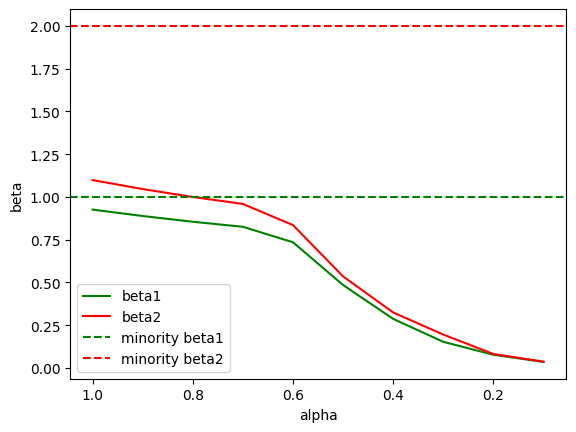

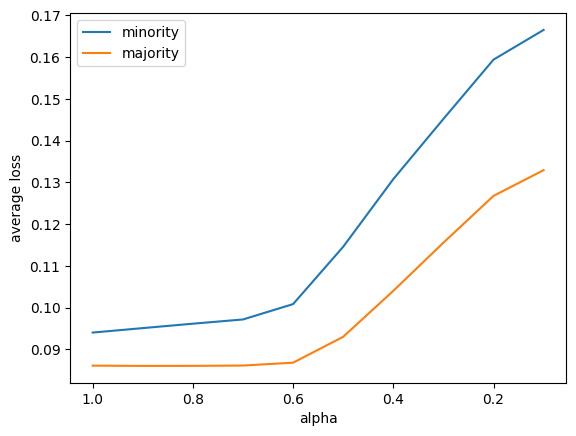

In [174]:
# plots
plt.plot(eps_candidates, beta_fitted[:,0], label = 'beta1', color = 'g')
plt.plot(eps_candidates, beta_fitted[:,1], label = 'beta2', color = 'r')
plt.axhline(y=beta_minor[0], color='g', linestyle='--', label='minority beta1')
plt.axhline(y=beta_minor[1], color='r', linestyle='--', label='minority beta2')
plt.xlabel('alpha')
plt.ylabel('beta')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

plt.plot(eps_candidates, test_loss[:,0], label = 'minority')
plt.plot(eps_candidates, test_loss[:,1], label = 'majority')
plt.xlabel('alpha')
plt.ylabel('average loss')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

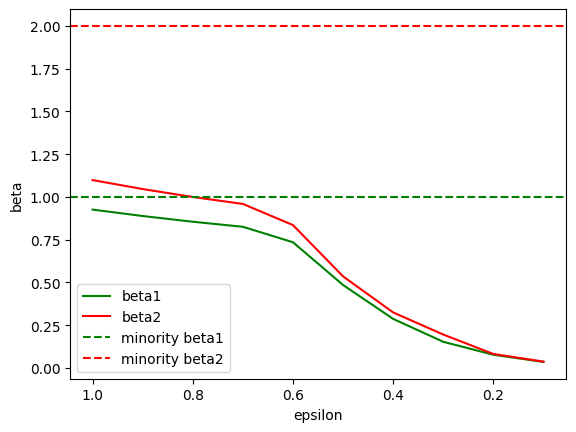

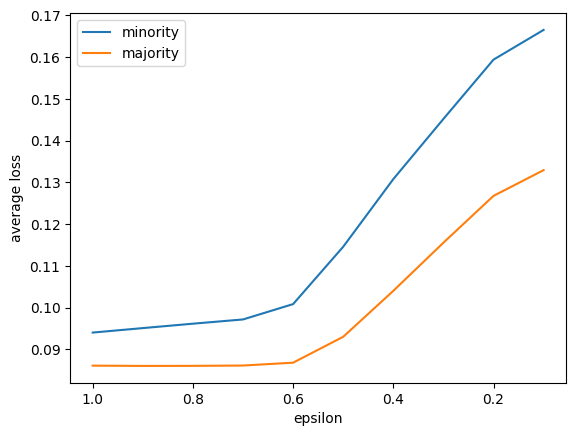

In [138]:
plt.plot(eps_candidates, beta_fitted[:,0], label = 'beta1', color = 'g')
plt.plot(eps_candidates, beta_fitted[:,1], label = 'beta2', color = 'r')
plt.axhline(y=beta_minor[0], color='g', linestyle='--', label='minority beta1')
plt.axhline(y=beta_minor[1], color='r', linestyle='--', label='minority beta2')
plt.xlabel('epsilon')
plt.ylabel('beta')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

plt.plot(eps_candidates, test_loss[:,0], label = 'minority')
plt.plot(eps_candidates, test_loss[:,1], label = 'majority')
plt.xlabel('epsilon')
plt.ylabel('average loss')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

### Infinitely many subpopulations

In [139]:
set_random_seed(1234)
sq_error_loss_indiv = lambda pred, y: (y - pred)**2

# Simulation configs
sim_n_train = 1000
sim_n_test = 10000
censor_rate = 0.4
beta_major = np.array([1,1])
beta_minor = np.array([1,2])
minor_prop = 0.1
S0_shape = 12.0
S0_scale = 1.0
G_dist = lambda n: np.random.beta(1, 2/3, n)

# Data generation
# Training set
sim_X_train = normal(size=(sim_n_train, len(beta_major)))
G_train = G_dist(sim_n_train)
log_hr_major_train = np.dot(sim_X_train, beta_major)
log_hr_minor_train = np.dot(sim_X_train, beta_minor)
log_hr_train = G_train*log_hr_major_train + (1-G_train)*log_hr_minor_train
sim_failure_time_train, sim_censor_time_train, sim_event_train, sim_time_train = simulate_weibull_failure_cox(log_hr_train, S0_shape=S0_shape, S0_scale=S0_scale, censor_rate=censor_rate)

# Test set
sim_X_test = normal(size=(sim_n_test, len(beta_major)))
log_hr_major_test = np.dot(sim_X_test, beta_major)
log_hr_minor_test = np.dot(sim_X_test, beta_minor)
G_test = binomial(1, 0.5, sim_n_test)
log_hr_test = G_test*log_hr_major_test + (1-G_test)*log_hr_minor_test
# sim_failure_time_major_test, sim_censor_time_major_test, sim_event_major_test, sim_time_major_test = simulate_weibull_failure_cox(log_hr_major_test, S0_shape=S0_shape, censor_rate=censor_rate)
# sim_failure_time_minor_test, sim_censor_time_minor_test, sim_event_minor_test, sim_time_minor_test = simulate_weibull_failure_cox(log_hr_minor_test, S0_shape=S0_shape, censor_rate=censor_rate)
sim_failure_time_test, sim_censor_time_test, sim_event_test, sim_time_test = simulate_weibull_failure_cox(log_hr_test, S0_shape=S0_shape, S0_scale=S0_scale, censor_rate=censor_rate)

# Arrays for storing simulation results
eps_candidates = np.linspace(0.1, 1.0, 10)
G_test_candidates = np.array([0, 1])
beta_fitted = np.zeros((len(eps_candidates), len(beta_major)))
eta_fitted = np.zeros((len(eps_candidates)))
dro_loss_fitted = np.zeros((len(eps_candidates)))
test_loss = np.zeros((len(eps_candidates), len(G_test_candidates)))
t_grids = np.linspace(*np.quantile(sim_time_train, [0.025, 0.975]), 100)

for eps_ind, eps in enumerate(eps_candidates):
    # Fit model
    model, eta_fitted[eps_ind] = fit_dro_cox(sim_X_train, sim_event_train, sim_time_train, eps=eps)
    beta_fitted[eps_ind,:] = next(model.parameters()).detach().numpy().reshape((-1,))
    surv_func = predict_survival_function(np.dot(sim_X_train, beta_fitted[eps_ind,:]), sim_event_train, sim_time_train, np.dot(sim_X_test, beta_fitted[eps_ind,:]))
    test_loss_indiv = integrated_bs_indiv(t_grids, surv_func, sim_failure_time_test)
    test_loss[eps_ind,0] = test_loss_indiv[G_test==0].mean()
    test_loss[eps_ind,1] = test_loss_indiv[G_test==1].mean()
    print(f"-----{eps:.2f}-----")

-----0.10-----
-----0.20-----
-----0.30-----
-----0.40-----
-----0.50-----
-----0.60-----
-----0.70-----
-----0.80-----
-----0.90-----
-----1.00-----


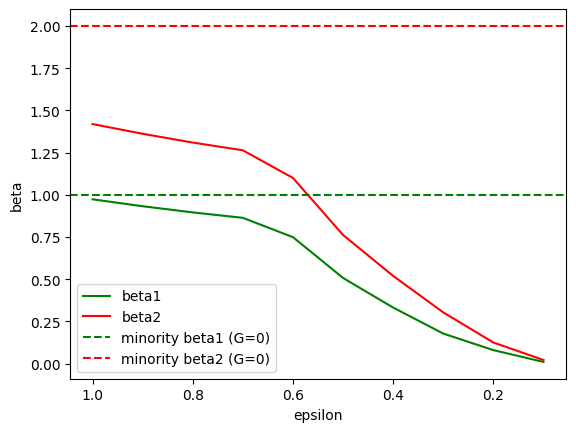

In [140]:
plt.plot(eps_candidates, beta_fitted[:,0], label = 'beta1', color = 'g')
plt.plot(eps_candidates, beta_fitted[:,1], label = 'beta2', color = 'r')
plt.axhline(y=beta_minor[0], color='g', linestyle='--', label='minority beta1 (G=0)')
plt.axhline(y=beta_minor[1], color='r', linestyle='--', label='minority beta2 (G=0)')
plt.xlabel('epsilon')
plt.ylabel('beta')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

In [141]:
G_test_candidates

array([0, 1])

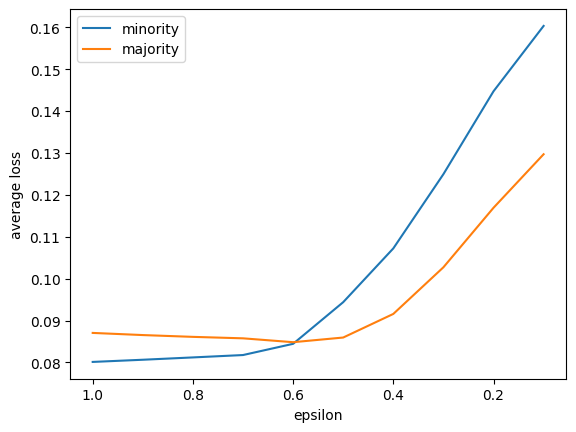

In [144]:
plt.plot(eps_candidates, test_loss[:,0], label = 'minority')
plt.plot(eps_candidates, test_loss[:,1], label = 'majority')
plt.xlabel('epsilon')
plt.ylabel('average loss')
plt.gca().invert_xaxis()
plt.legend()
plt.show()